# Data Exploration for a Machine Learning Stock Predictor

In [104]:
# import needed libraries
import os
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 15.0)

## Helper functions
---

Global functions intended to make computations and exploration easier.

In [105]:

################################################
# Data Gathering Helpers
################################################
def path_to_data(ticker, base_dir='data'):
    return os.path.join(base_dir, '{}.csv'.format(ticker))

#
# returns the full data set of a single stock for visualization.
#
def example_full_data(ticker, dates):
    df = pd.DataFrame(index=dates)
    df = pd.read_csv(
            path_to_data(ticker), 
            index_col='Date', 
            parse_dates=True, 
            na_values=['nan'])
    return df

#
# Takes a list of stock symbols and returns a new data set filtered down to
# the data as an index, the symbols as column names and the values of the columns
# that stocks adjusted closing price.
#
def fetch_data(ticker_list, dates):
    df = pd.DataFrame(index=dates)
    
    if 'SPY' not in ticker_list:
        ticker_list.insert(0, 'SPY')
        
    for ticker in range(0, len(ticker_list)):
        df_temp = pd.read_csv(
            path_to_data(ticker_list[ticker]), 
            usecols=['Date', 'Adj Close'], 
            index_col='Date', 
            parse_dates=True, 
            na_values=['nan'])
        df_temp = df_temp.rename(columns={'Adj Close' : ticker_list[ticker]})
        df = df.join(df_temp)
    
    df = df.dropna(subset=['SPY'])
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

################################################
# STATS Helpers
################################################

#
# normalize the price of the data so each stock starts at zero
# in order to truly see how they are doing compared to the S&P 500
#
def normalize_data(df):
    return df/df.iloc[0,:]

#
# Print the stats of each stock
#
def print_stats(df):
    print 'Global Mean:'
    print df.mean()
    print '\nGlobal Median:'
    print df.median()
    print '\nGlobal Std:'
    print df.std()

#
# Calculate the daily returns of each stock
#
def get_daily_returns(df):
    daily_returns = df.copy()
    daily_returns[1:] = (daily_returns[1:] / daily_returns[0:-1].values) - 1
    daily_returns.iloc[0, : ] = 0
    return daily_returns

#
# Calculate the rolling mean of
# each stock. Window value can change to
# optimize the results
#
def get_rolling_mean(vals, window=20):
    return vals.rolling(window,center=False).mean()

#
# Calculate the rolling STD of
# each stock. Window value can change to
# optimize the results
#
def get_rolling_std(vals, window=20):
    return vals.rolling(window,center=False).std()

#
# Calculate the Bollinger Bands of each stock
# This will be one of the defining features
#
def get_bollinger_bands(rolling_mean, rolling_std):
    lower_band = rolling_mean - (rolling_std * 2)
    upper_band = rolling_mean + (rolling_std * 2)
    return lower_band, upper_band

#
# Calculate the Bollinger Bands Ratios
# This will be one of the defining features
#
def get_bollinger_ratios(series, sma, r_std, window=20):
    bb = series.copy()
    bb[window:] = (bb[window:] - sma[window:]) / (2 * r_std[window:])
    return bb[window:]

#
# Return the momentum of each stock.
# The goal is to visulaize when a stock is going up
# or going down
#
def get_momentum(df, window=20):
    momentum = df.copy()
    momentum[window:] = (momentum[window:] / momentum[0:-window].values) - 1
    return momentum[window:]

#
# Returns the SMA ratio
#
def get_sma_ratio(df, window=20):
    sma = df.copy()
    sma[window:] = (sma[window:] / sma[0:-window].mean()) - 1
    return sma[window:]

#
# normalize the features so they are all within the same range
#
def normalize_feature(series):
    return (series - series.mean())/series.std()

################################################
# Graph Plotting Helpers
################################################
def plot_hist_with_stats(df, bins=10, title=''):
    
    mean = df.mean()
    std = df.std()
    
    df.hist(bins=bins)
    plt.axvline(mean, color='w', linestyle='dashed', linewidth=2)
    plt.axvline(mean + std, color='r', linestyle='dashed', linewidth=2)
    plt.axvline(mean - std, color='r', linestyle='dashed', linewidth=2)
    plt.show()

def plot_hist_multi(df, bins=10, title=''):
    for stock in df:
        df[stock].hist(bins=bins, label=stock, alpha = 0.5)
    plt.legend(loc='best')
    plt.show()
    
def print_bollinger_bands(series, rolling_mean, lower_band, upper_band, label=''):
    val = ax = series.plot(title='', label='Prices', fontsize=10)
    rm = rolling_mean.plot(label='Rolling Mean', ax=ax)
    ub = upper_band.plot(label='Upper Band', ax=ax)
    lb = lower_band.plot(label='Lower Band', ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='best')
    ax.set_xlabel('Dates')
    ax.set_ylabel('Adjusted Close')
    plt.show()
    
def plot_momentum(series, rolling_mean, label=''):
    val = ax = series.plot(title='Momentum: ' + label, label='Prices', fontsize=10)
    rm = rolling_mean.plot(label='Rolling Mean', ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='best')
    plt.show()
    
def plot_data(df, title='Stock Prices', xlabel='Date', ylabel='Price'):
    ax = df.plot(title=title, fontsize=14)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()
    
def plot_predictions(true_vals, pred_vals, x_label='Actual', y_label='CLF Predictions'):
    fig, ax = plt.subplots()
    ax.scatter(actual_vals, pred_vals)
    ax.plot([pred_vals.min(), pred_vals.max()], [pred_vals.min(), pred_vals.max()], 'k--', lw=4)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show()

## Process Data for Selected Stocks
---

In [106]:
# use two years of dates for data exploration
dates = pd.date_range('2015-07-14', '2017-07-14')

# four stocks used for evaluation
# final implimentation will also use
# four stocks at max
tickers = ['NVDA', 'IBM', 'GOOG', 'AAPL']

# window size for rolling stats
metrics_window = 10

df_full_example = example_full_data('SPY', dates)
df_explore = fetch_data(tickers, dates)

print 'Exapmle of Full Data Set of SPY (Benchmark)'
print df_full_example.head(n=5)
print '\n\nTop of the data as it will be used, filtered down to adjusted price.'
print df_explore.head(n=5)

Exapmle of Full Data Set of SPY (Benchmark)
                  Open        High         Low      Close   Adj Close  \
Date                                                                    
2010-07-15  109.610001  110.059998  108.169998  95.017952  109.680000   
2010-07-16  109.089996  109.209999  106.449997  92.401672  106.660004   
2010-07-19  107.050003  107.629997  106.220001  92.947449  107.290001   
2010-07-20  105.870003  108.559998  105.820000  93.978371  108.480003   
2010-07-21  109.040001  109.070000  106.629997  92.756844  107.070000   

               Volume  
Date                   
2010-07-15  232337900  
2010-07-16  282693400  
2010-07-19  186709000  
2010-07-20  258162400  
2010-07-21  264527000  


Top of the data as it will be used, filtered down to adjusted price.
                   SPY       NVDA         IBM        GOOG        AAPL
2015-07-14  210.679993  19.889999  168.610001  561.099976  125.610001
2015-07-15  210.610001  19.750000  168.529999  560.219971  126.82

## Visualize the Data of the Selected Stocks
---
In this section we now viualize the data sets based on date and adjusted closing values.
The second graph is normalized in order to visualize the true volitility of each stock
agains the S&P 500

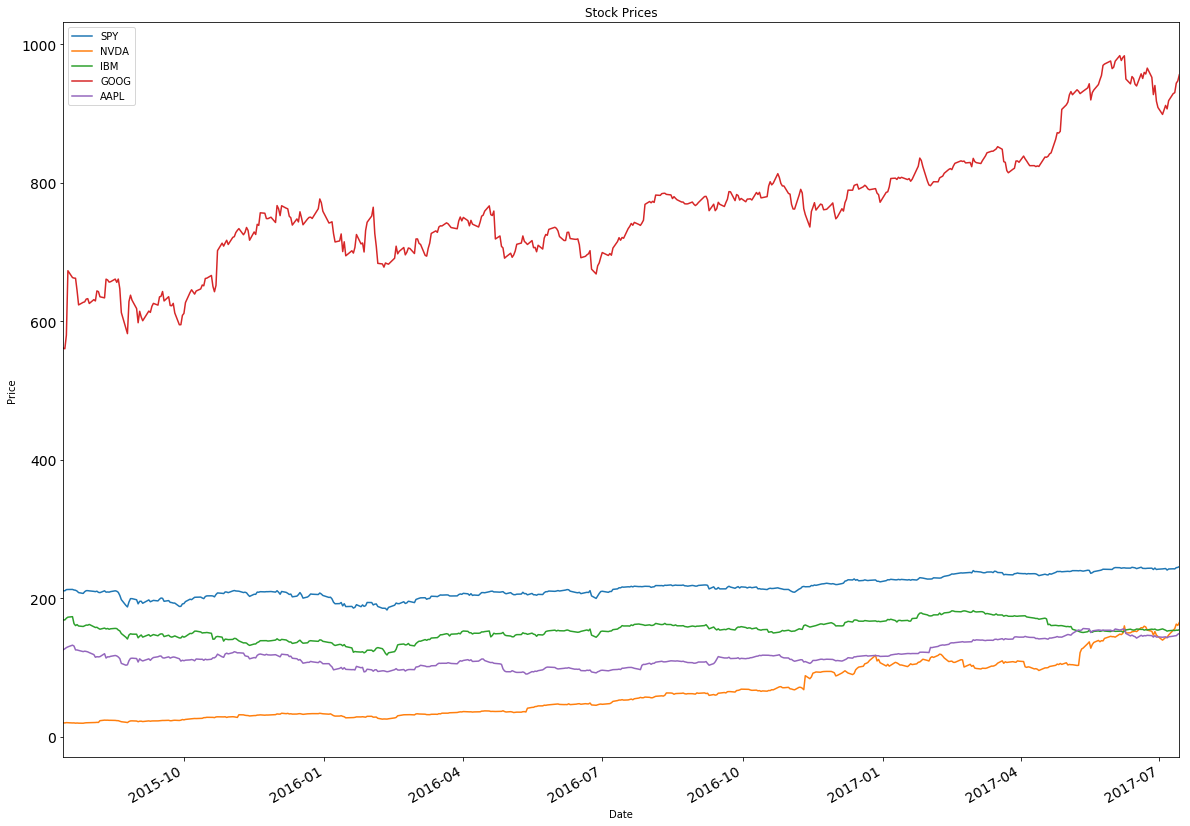

In [107]:
plot_data(df_explore)

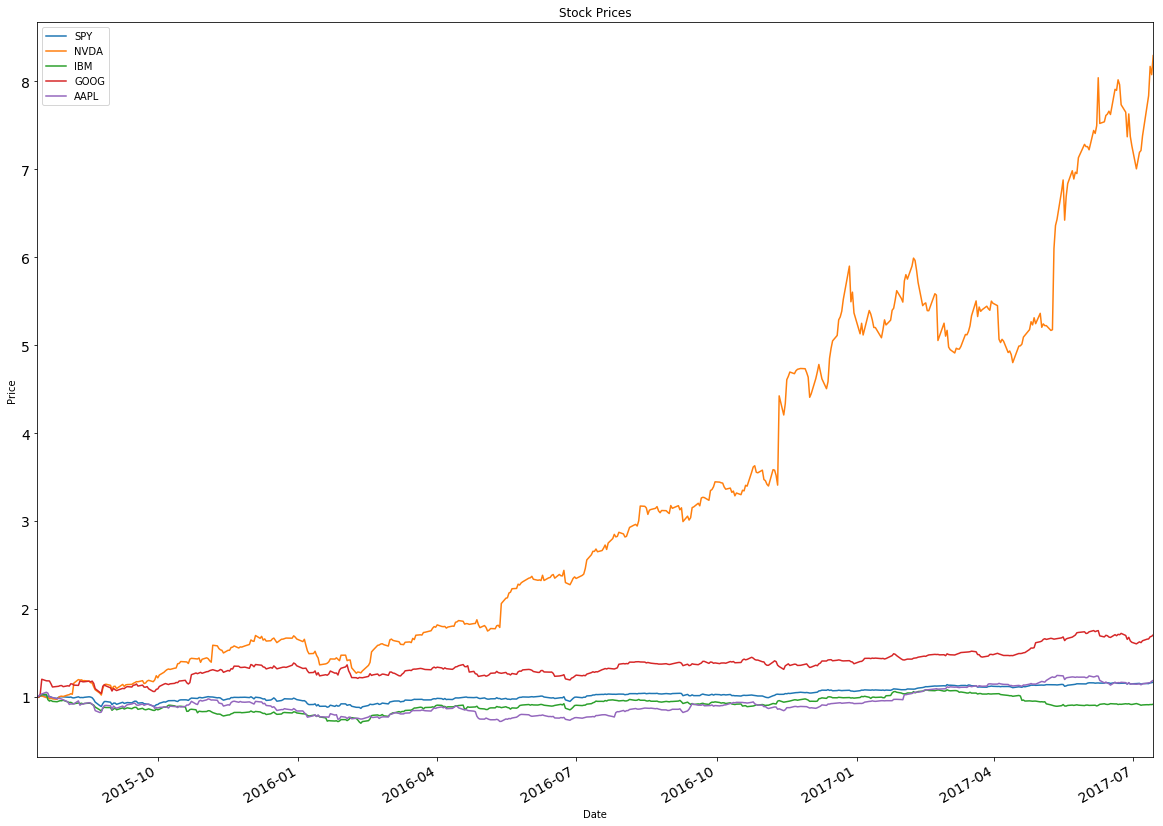

In [108]:
normalized_data = normalize_data(df_explore)
plot_data(normalized_data)

Based on the printed graphs we can see that NVDA is signigicanly more volitile over the two year period than the benchmark S&P 500 and the other stocks evaluated

## Global Stats
---

Global stats of the stocks we are interested in


In [109]:
print_stats(normalized_data)

Global Mean:
SPY     1.021891
NVDA    3.246513
IBM     0.910470
GOOG    1.357082
AAPL    0.927906
dtype: float64

Global Median:
SPY     1.008686
NVDA    2.654098
IBM     0.909703
GOOG    1.347870
AAPL    0.899809
dtype: float64

Global Std:
SPY     0.072933
NVDA    1.982375
IBM     0.078761
GOOG    0.154974
AAPL    0.134810
dtype: float64


## Rolling Stats
---
Visualization of the rolling stats

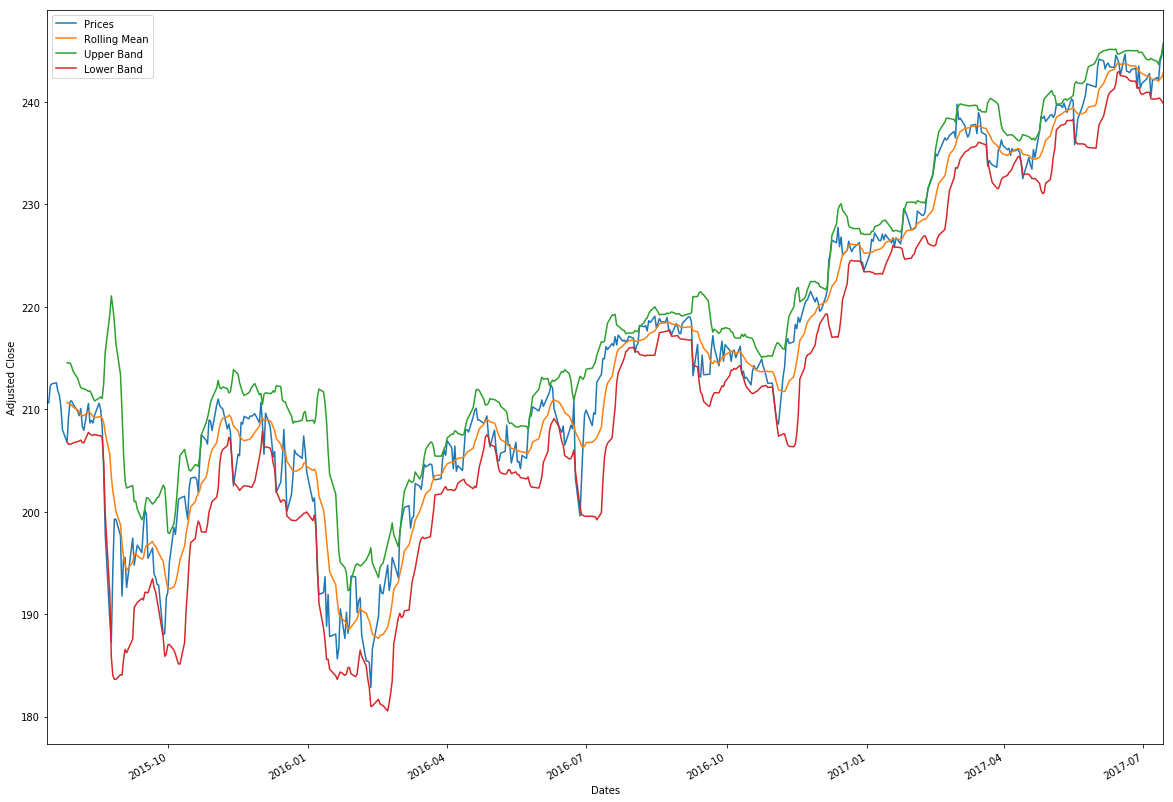

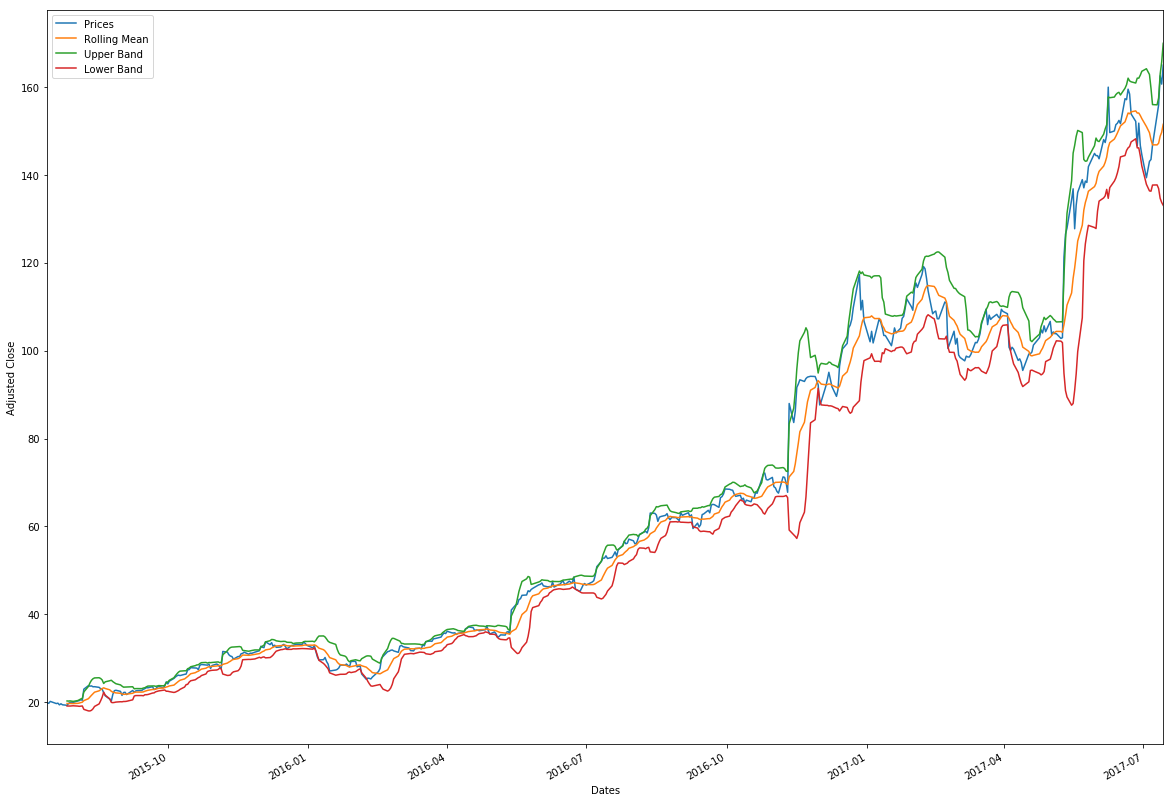

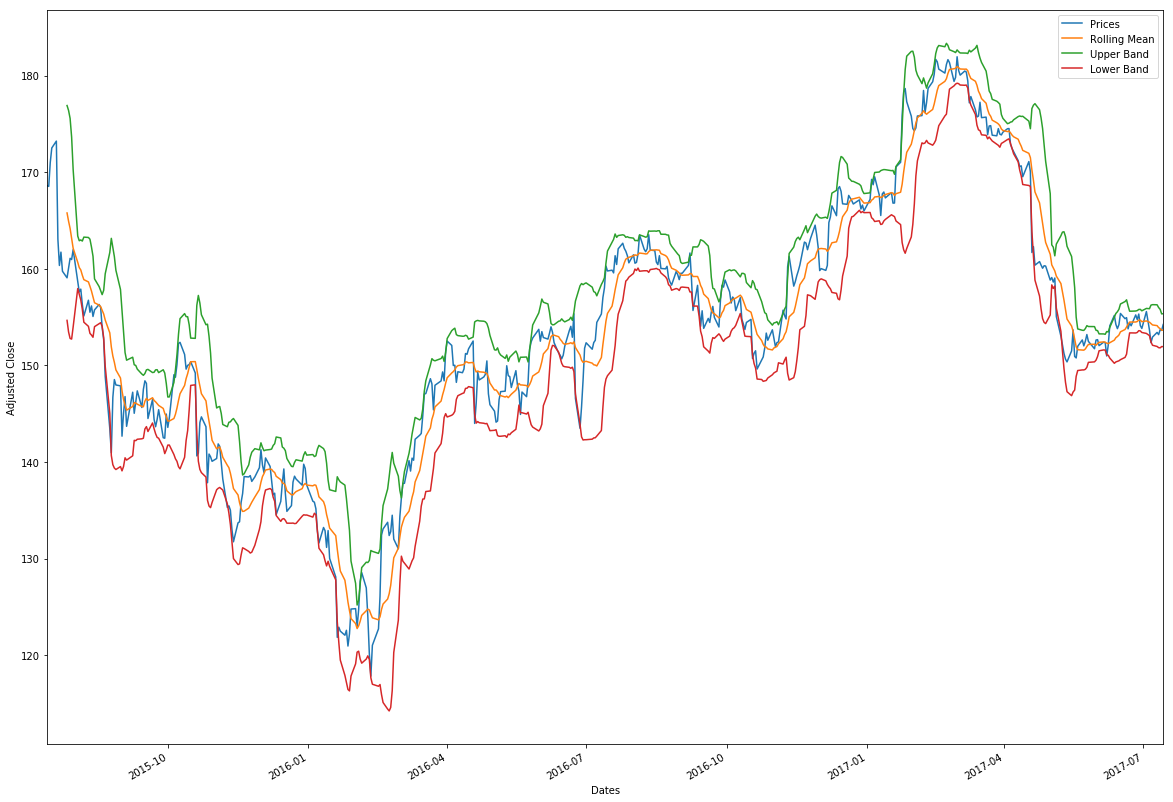

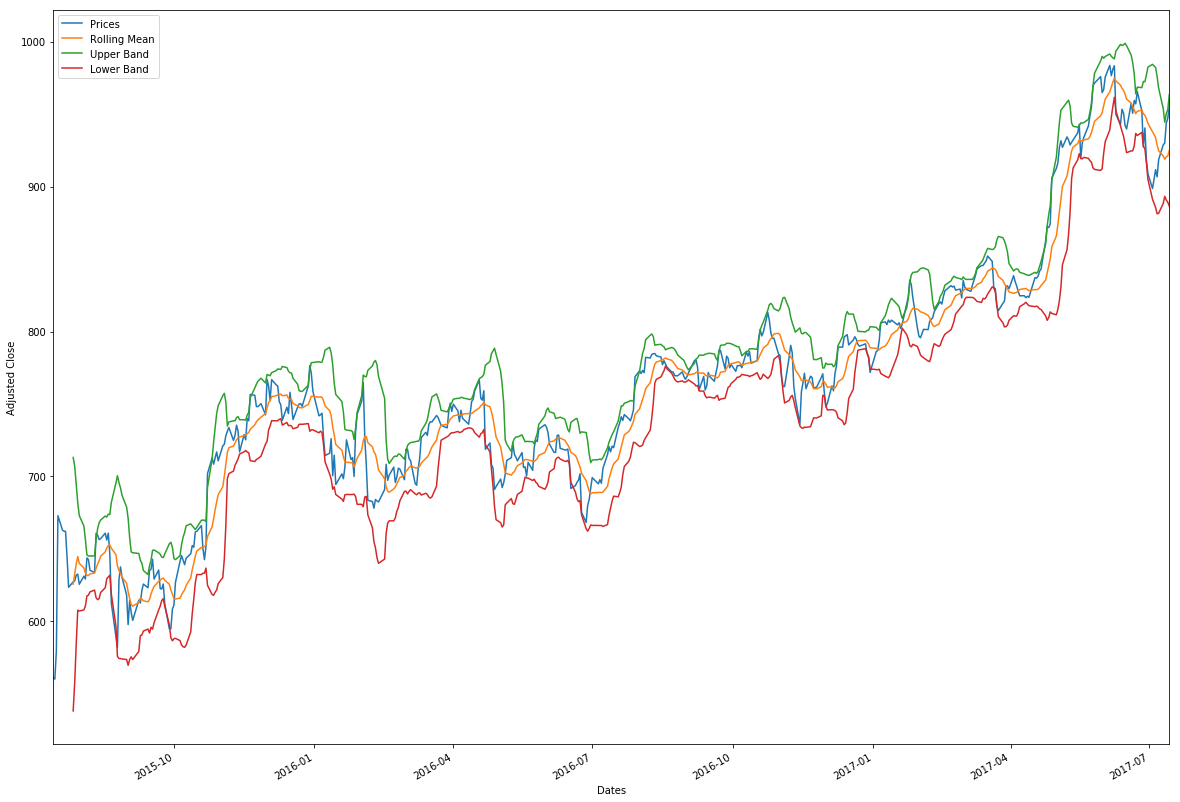

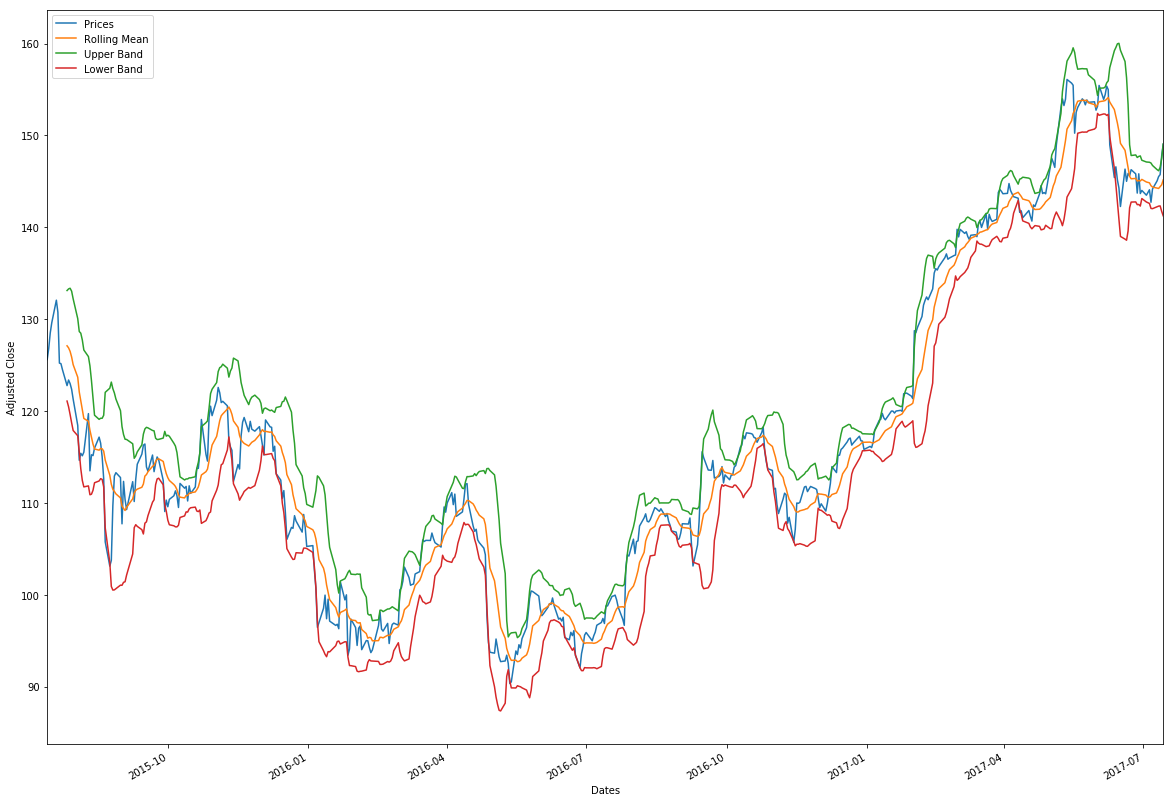

In [ ]:
for symbol in tickers:
    rolling_mean = get_rolling_mean(df_explore[symbol], metrics_window)
    rolling_std = get_rolling_std(df_explore[symbol], metrics_window)
    lower_band, upper_band = get_bollinger_bands(rolling_mean, rolling_std)
    print_bollinger_bands(df_explore[symbol], rolling_mean, lower_band, upper_band, symbol)

## Daily Returns
---
Visualization of daily returns

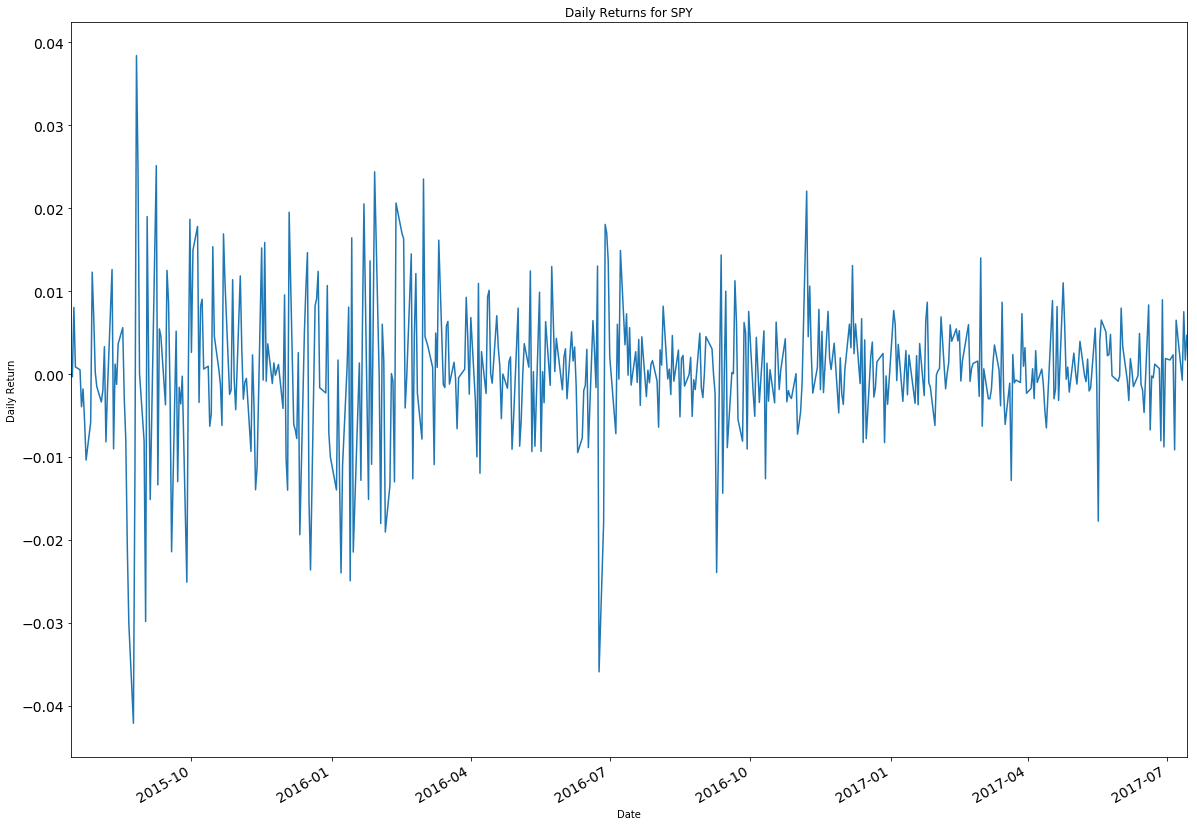

Max/Min Daily Returns for SPY
Max: 0.0383937782155
Min: -0.0421068691088





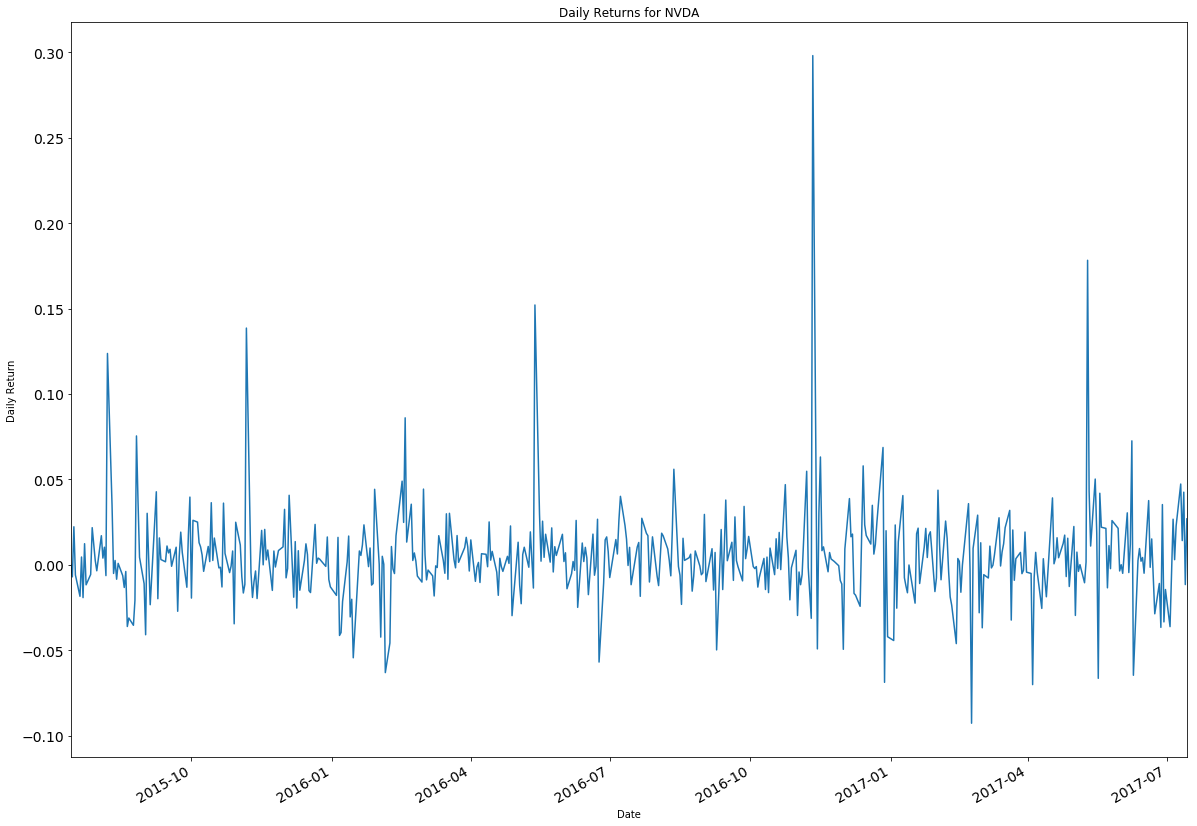

Max/Min Daily Returns for NVDA
Max: 0.298067063512
Min: -0.0927230391347





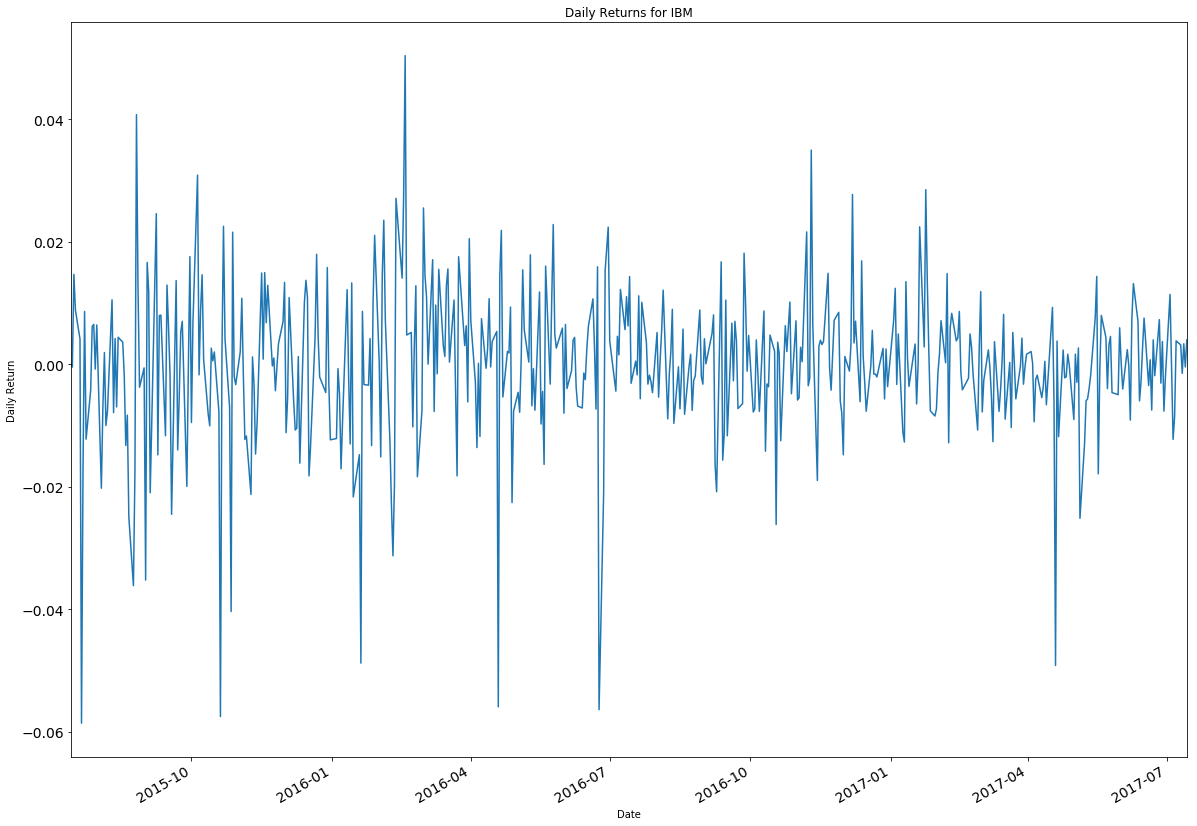

Max/Min Daily Returns for IBM
Max: 0.0503568525037
Min: -0.0585959701039





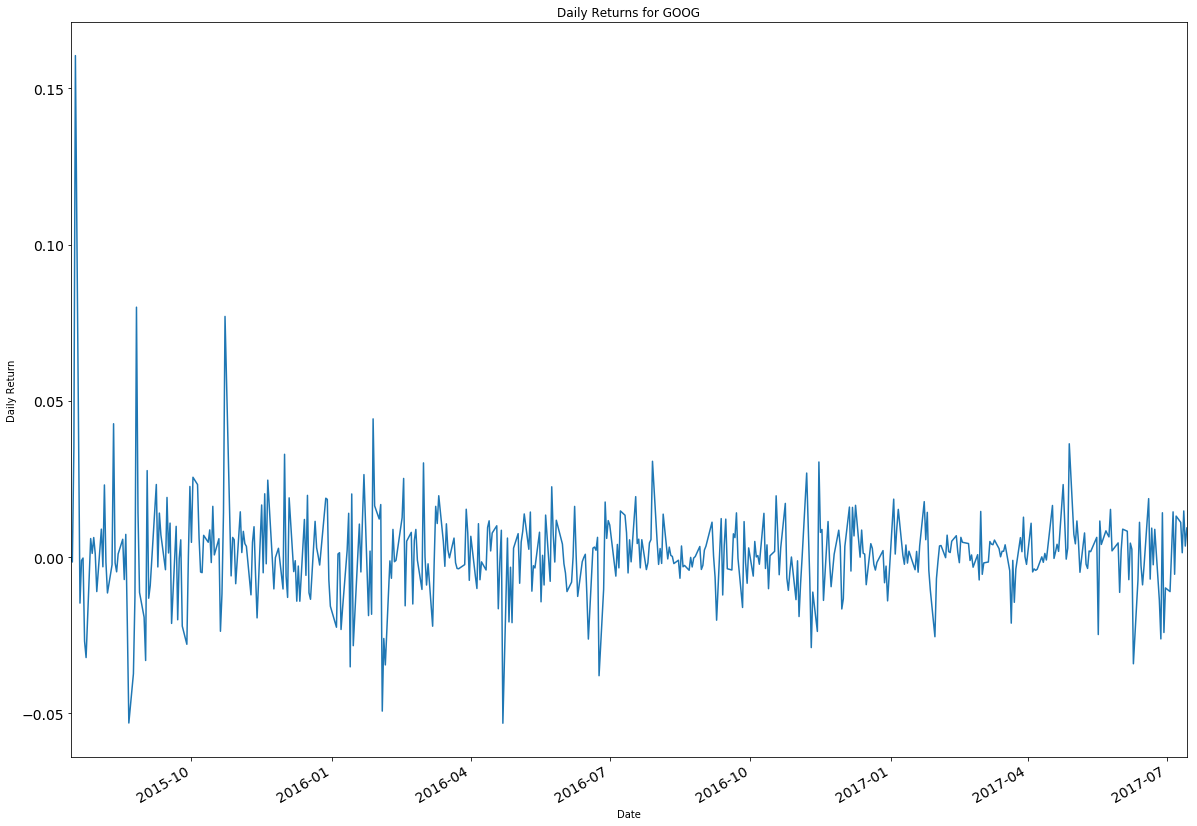

Max/Min Daily Returns for GOOG
Max: 0.160524309481
Min: -0.0531785891961





In [ ]:
daily_returns  = get_daily_returns(df_explore)
for symbol in tickers:
    plot_data(daily_returns[symbol], title='Daily Returns for ' + symbol, xlabel='Date', ylabel='Daily Return')

    print 'Max/Min Daily Returns for ' + symbol
    print 'Max:', daily_returns[symbol].max()
    print 'Min:', daily_returns[symbol].min()
    print '\n\n'

In [ ]:
plot_hist_multi(daily_returns, bins=15)

## Momentum
---

In [ ]:
for symbol in tickers:
    momentum = get_momentum(df_explore[symbol], window=metrics_window)
    plot_data(momentum, title='Momentum of ' + symbol, xlabel='Date', ylabel='Momentum')
    plot_hist_with_stats(momentum, bins=40)

    print 'Max/Min Momentum for ' + symbol
    print 'Max:', momentum.max()
    print 'Min:', momentum.min()
    print '\n\n'

## Simple Moving Average Ratio
---

In [ ]:
for symbol in tickers:
    sma_ratios = get_sma_ratio(df_explore[symbol], window=metrics_window)

    plot_data(sma_ratios, title='SMA Ratios of ' + symbol, xlabel='Date', ylabel='SMA Ratio[Day]')
    plot_hist_with_stats(sma_ratios, bins=40)

    print 'Max/Min SMA Ratio for ' + symbol
    print 'Max: ', sma_ratios.max()
    print 'Min: ', sma_ratios.min()

## Bolinger Ratios
---

In [ ]:
for symbol in tickers:
    bb_ratios = get_bollinger_ratios(series=df_explore[symbol], sma=rolling_mean, r_std=rolling_std, window=metrics_window)

    plot_data(bb_ratios, title='Bollinger Ratios of ' + symbol, xlabel='Date', ylabel='Bollinger Ratio[Day]')
    plot_hist_with_stats(bb_ratios, bins=20, title=symbol)

    print 'Max/Min BB Ratio for ' + symbol
    print 'Max:', bb_ratios.max()
    print 'Min:', bb_ratios.min()

## Example Set Up of the Feature Set
---


In [ ]:
# The final features to be used will be the Bollinger Bands Ratio,
# the momentum, and the Simple Moving Average Ratio. The three values
# are easlity converted into numerical values suitable for Machine Learning
# aglorithms

# This is an example set of features to be passed to the ML algos in the following sections

# recombine the features into a new Data Frame X and Y. 
# X will be a frame of all the featres for and Y will be the outcomes

# NVDA as the example
rolling_mean = get_rolling_mean(df_explore['SPY'], metrics_window)
rolling_std = get_rolling_std(df_explore['SPY'], metrics_window)

d = { 
    'BB_RATIOS' : get_bollinger_ratios(series=df_explore['SPY'], sma=rolling_mean, r_std=rolling_std, window=metrics_window), 
    'SMA_RATIOS' : get_sma_ratio(df_explore['SPY'], window=metrics_window), 
    'MOMENTUM' : get_momentum(df_explore['SPY'], window=metrics_window)
}
features_df = pd.DataFrame(d)

X_features = features_df[0 : -1].values
y_target = df_explore['SPY'][(metrics_window + 1) : ].values

print 'Features Length', len(X_features)
print 'Target Length', len(y_target)
print features_df.head()


In [ ]:
pd.scatter_matrix(features_df, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

## Machine Learning Algos
---
The final following sections will run each test stock through a few different machine learning algorithms to determine the best model to be used for our predictions. The chosen algos that are believed to be the best fit for the data type are KNN, a simple linear regression, and a Random Forrest.

## KNN
---

In [ ]:
for symbol in tickers:
    
    rolling_mean = get_rolling_mean(df_explore[symbol], metrics_window)
    rolling_std = get_rolling_std(df_explore[symbol], metrics_window)

    d = { 
        'BB_RATIOS' : get_bollinger_ratios(series=df_explore[symbol], sma=rolling_mean, r_std=rolling_std, window=metrics_window), 
        'SMA_RATIOS' : get_sma_ratio(df_explore[symbol], window=metrics_window), 
        'MOMENTUM' : get_momentum(df_explore[symbol], window=metrics_window)
    }
    features_df = pd.DataFrame(d)

    X_features = features_df[0 : -1].values
    y_target = df_explore[symbol][(metrics_window + 1) : ].values


    pipe_knn = Pipeline([
            ('scl', StandardScaler()),
            ('clf', KNeighborsRegressor(n_neighbors=5, weights='distance'))
        ])

    tscv = TimeSeriesSplit(n_splits=3)
    train_scores = []
    test_scores = []

    final_predics = []
    actual_vals = []

    for train_index, test_index in tscv.split(X_features):
        
        pipe_knn.fit(X_features[train_index], y_target[train_index])

        train_score = pipe_knn.score(X_features[train_index], y_target[train_index])
        test_score = pipe_knn.score(X_features[test_index], y_target[test_index])

        train_scores.append(train_score)
        test_scores.append(test_score)

        final_predic = pipe_knn.predict(X_features[test_index])
        actual_vals = y_target[test_index]
    
    print 'KNN Evaluation and scores for ', symbol
    print '\nTrain scores', train_scores
    print 'Train Scores Mean {}, Train Scores STD {}'.format(np.asarray(train_scores).mean(), np.asarray(train_scores).std())

    print '\nTest scores', test_scores
    print 'Test Scores Mean {}, Test Scores STD {}'.format(np.asarray(test_scores).mean(), np.asarray(test_scores).std())

    print '\nPredictions', final_predic[0: 12]

    print '\nActual', actual_vals[0: 12]

    plot_predictions(actual_vals, final_predic, y_label='KNN Predictions')
    print '\n\n'

## Linear Regression 
---

In [ ]:
for symbol in tickers:
        
    rolling_mean = get_rolling_mean(df_explore[symbol], metrics_window)
    rolling_std = get_rolling_std(df_explore[symbol], metrics_window)

    d = { 
        'BB_RATIOS' : get_bollinger_ratios(series=df_explore[symbol], sma=rolling_mean, r_std=rolling_std, window=metrics_window), 
        'SMA_RATIOS' : get_sma_ratio(df_explore[symbol], window=metrics_window), 
        'MOMENTUM' : get_momentum(df_explore[symbol], window=metrics_window)
    }
    features_df = pd.DataFrame(d)

    X_features = features_df[0 : -1].values
    y_target = df_explore[symbol][(metrics_window + 1) : ].values
    
    pipe_lr = Pipeline([
            ('scl', StandardScaler()),
            ('clf', LinearRegression())
        ])

    tscv = TimeSeriesSplit(n_splits=3)
    train_scores = []
    test_scores = []

    final_predics = []
    actual_vals = []

    for train_index, test_index in tscv.split(X_features):
        pipe_lr.fit(X_features[train_index], y_target[train_index])

        train_score = pipe_lr.score(X_features[train_index], y_target[train_index])
        test_score = pipe_lr.score(X_features[test_index], y_target[test_index])

        train_scores.append(train_score)
        test_scores.append(test_score)

        final_predic = pipe_lr.predict(X_features[test_index])
        actual_vals = y_target[test_index]

    print 'Linear Regression Evaluation and scores for ', symbol
    print '\nTrain scores', train_scores
    print 'Train Scores Mean {}, Train Scores STD {}'.format(np.asarray(train_scores).mean(), np.asarray(train_scores).std())

    print '\nTest scores', test_scores
    print 'Test Scores Mean {}, Test Scores STD {}'.format(np.asarray(test_scores).mean(), np.asarray(test_scores).std())

    print '\nPredictions', final_predic[0: 12]

    print '\nActual', actual_vals[0: 12]

    plot_predictions(actual_vals, final_predic, y_label='Predicted')
    print '\n\n'

## Random Forests

In [ ]:
for symbol in tickers:
        
    rolling_mean = get_rolling_mean(df_explore[symbol], metrics_window)
    rolling_std = get_rolling_std(df_explore[symbol], metrics_window)

    d = { 
        'BB_RATIOS' : get_bollinger_ratios(series=df_explore[symbol], sma=rolling_mean, r_std=rolling_std, window=metrics_window), 
        'SMA_RATIOS' : get_sma_ratio(df_explore[symbol], window=metrics_window), 
        'MOMENTUM' : get_momentum(df_explore[symbol], window=metrics_window)
    }
    features_df = pd.DataFrame(d)

    X_features = features_df[0 : -1].values
    y_target = df_explore[symbol][(metrics_window + 1) : ].values

    clf_rf = RandomForestRegressor(n_estimators=5)
    tscv = TimeSeriesSplit(n_splits=3)

    train_scores = []
    test_scores = []

    final_predics = []
    actual_vals = []

    for train_index, test_index in tscv.split(X_features):
        clf_rf.fit(X_features[train_index], y_target[train_index])

        train_score = clf_rf.score(X_features[train_index], y_target[train_index])
        test_score = clf_rf.score(X_features[test_index], y_target[test_index])

        train_scores.append(train_score)
        test_scores.append(test_score)

        final_predic = clf_rf.predict(X_features[test_index])
        actual_vals = y_target[test_index]
    
    print 'Random Forests Evaluation and scores for ', symbol
    print '\nTrain scores', train_scores
    print 'Train Scores Mean {}, Train Scores STD {}'.format(np.asarray(train_scores).mean(), np.asarray(train_scores).std())

    print '\nTest scores', test_scores
    print 'Test Scores Mean {}, Test Scores STD {}'.format(np.asarray(test_scores).mean(), np.asarray(test_scores).std())

    print '\nPredictions', final_predic[0: 12]

    print '\nActual', actual_vals[0: 12]

    plot_predictions(actual_vals, final_predic, y_label='Random Forest Predictions')
    print '\n\n'